### Activator system

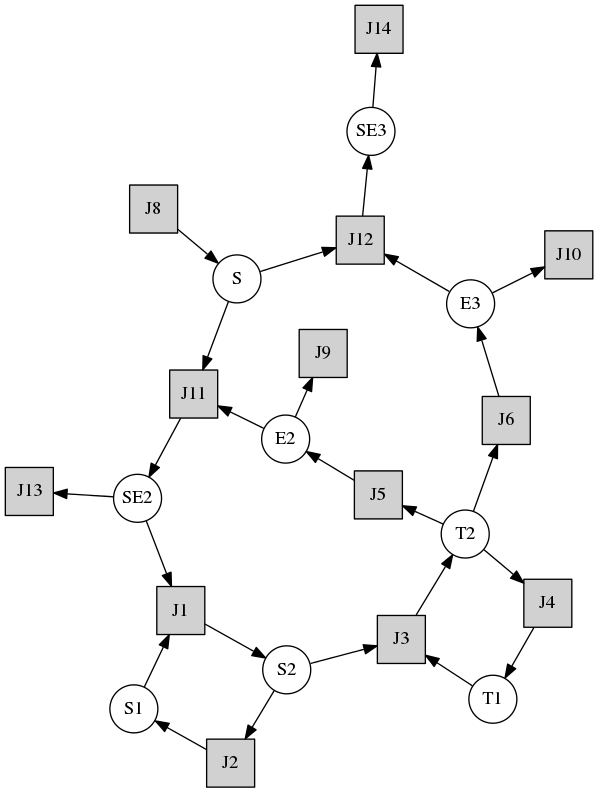

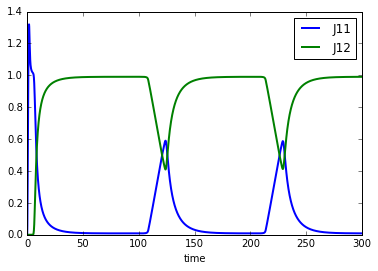

In [1]:
%matplotlib inline
import tellurium as te

# model Definition
r = te.loada ('''
        #J1: S1 -> S2; Activator*kcat1*S1/(Km1+S1);
        J1: S1 -> S2; SE2*kcat1*S1/(Km1+S1);
        J2: S2 -> S1; Vm2*S2/(Km2+S2);
        
        J3: T1 -> T2; S2*kcat3*T1/(Km3+T1);
        J4: T2 -> T1; Vm4*T2/(Km4+T2);
        
        J5:    -> E2; Vf5/(Ks5+T2^h5);
        J6:    -> E3; Vf6*T2^h6/(Ks6+T2^h6);
        
        #J7:    -> E1;
        J8:    ->  S; kcat8*E1
        
        J9: E2 ->   ; k9*E2;
        J10:E3 ->   ; k10*E3;
        
        J11: S -> SE2; E2*kcat11*S/(Km11+S);
        J12: S -> SE3; E3*kcat12*S/(Km12+S);
        
        J13: SE2 ->  ; SE2*kcat13; 
        J14: SE3 ->  ; SE3*kcat14; 
        
        Km1 = 0.01; Km2 = 0.01; Km3 = 0.01; Km4 = 0.01; Km11 = 1; Km12 = 0.1;
        S1 = 6; S2 =0.1; T1=6; T2 = 0.1;
        SE2 = 0; SE3=0;
        S=0;
        E2 = 0; E3 = 0;
        kcat1 = 0.1; kcat3 = 3; kcat8 =1; kcat11 = 1; kcat12 = 1; kcat13 = 0.1; kcat14=0.1;
        E1 = 1;
        k9 = 0.1; k10=0.1;
        Vf6 = 1;
        Vf5 = 3;
        Vm2 = 0.1;
        Vm4 = 2;
        h6 = 2; h5=2;
        Ks6 = 1; Ks5 = 1;
        Activator = 0;

        at (time > 100): Activator = 5;  
''')
r.draw(width=300)
r.conservedMoietyAnalysis = True
result = r.simulate (0, 300, 2000, ['time', 'J11', 'J12']);
r.plot(result);

In [2]:
### Feedback oscillations

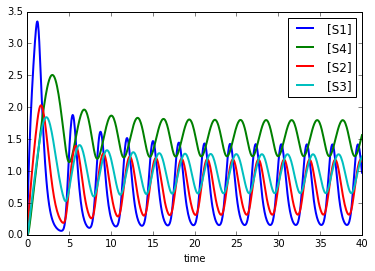

In [3]:
# http://tellurium.analogmachine.org/testing/
import tellurium as te
r = te.loada ('''
model feedback()
   // Reactions:
   J0: $X0 -> S1; (VM1 * (X0 - S1/Keq1))/(1 + X0 + S1 +   S4^h);
   J1: S1 -> S2; (10 * S1 - 2 * S2) / (1 + S1 + S2);
   J2: S2 -> S3; (10 * S2 - 2 * S3) / (1 + S2 + S3);
   J3: S3 -> S4; (10 * S3 - 2 * S4) / (1 + S3 + S4);
   J4: S4 -> $X1; (V4 * S4) / (KS4 + S4);

  // Species initializations:
  S1 = 0; S2 = 0; S3 = 0;
  S4 = 0; X0 = 10; X1 = 0;

  // Variable initialization:
  VM1 = 10; Keq1 = 10; h = 10; V4 = 2.5; KS4 = 0.5;
end''')

r.integrator.setValue('variable_step_size', True)
res = r.simulate(0, 40)
r.plot();

### Bistable System
Example showing how to to multiple time course simulations, merging the data and plotting it onto one platting surface. Alternative is to use setHold()

Model is a bistable system, simulations start with different initial conditions resulting in different steady states reached.

['time', '[S1]']


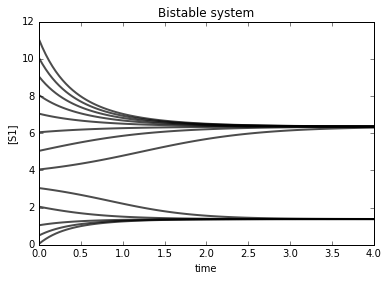

In [4]:
import tellurium as te
import numpy as np

r = te.loada ('''
$Xo -> S1; 1 + Xo*(32+(S1/0.75)^3.2)/(1 +(S1/4.3)^3.2);
S1 -> $X1; k1*S1;

Xo = 0.09; X1 = 0.0;
S1 = 0.5; k1 = 3.2;
''')
print(r.selections)

initValue = 0.05
m = r.simulate (0, 4, 100, selections=["time", "S1"])

for i in range (0,12):
    r.reset()
    r['[S1]'] = initValue
    res = r.simulate (0, 4, 100, selections=["S1"])
    m = np.concatenate([m, res], axis=1)
    initValue += 1

te.plotArray(m, color="black", alpha=0.7, loc=None, 
             xlabel="time", ylabel="[S1]", title="Bistable system");

### Add plot elements

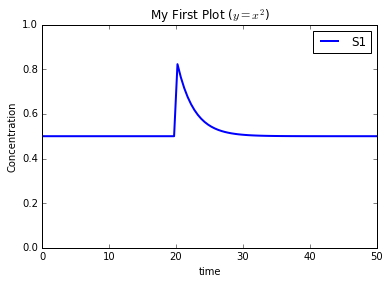

In [5]:
import tellurium as te
import numpy
import matplotlib.pyplot as plt
import roadrunner

# Example showing how to embelise a graph, change title, axes labels.
# Example also uses an event to pulse S1

r = te.loada ('''
   $Xo -> S1; k1*Xo;
   S1 -> $X1; k2*S1;
   
   k1 = 0.2; k2 = 0.4; Xo = 1; S1 = 0.5;
   at (time > 20): S1 = S1 + 0.35
''')

# Simulate the first part up to 20 time units
m = r.simulate (0, 50, 100, ["time", "S1"]);

plt.ylim ((0,1))
plt.xlabel ('Time')
plt.ylabel ('Concentration')
plt.title ('My First Plot ($y = x^2$)')
r.plot(m);

### Events

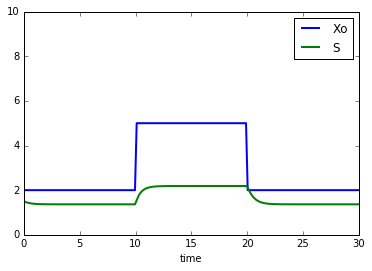

In [6]:
import tellurium as te
import matplotlib.pyplot as plt

# Example showing use of events and how to set the y axis limits
r = te.loada ('''
  $Xo -> S;   Xo/(km + S^h);
  S -> $w;  k1*S;       

     # initialize
     h = 1;   # Hill coefficient
     k1 = 1;  km = 0.1;
     S = 1.5; Xo = 2
     
     at (time > 10): Xo = 5;
     at (time > 20): Xo = 2;
''')

m1 = r.simulate (0, 30, 200, ['time', 'Xo', 'S'])

plt.ylim ((0,10))
r.plot(m1);

### Gene network

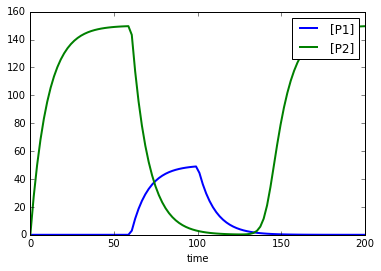

In [7]:
import tellurium as te
import numpy

# Model desribes a cascade of two genes. First gene is activated
# second gene is repressed. Uses events to change the input 
# to the gene regulatory network

r = te.loada ('''
    v1:  -> P1; Vm1*I^4/(Km1 + I^4);
    v2:  P1 -> ; k1*P1;
    v3:  -> P2;  Vm2/(Km2 + P1^4);
    v4:  P2 -> ; k2*P2;
    
    at (time > 60): I = 10;
    at (time > 100): I = 0.01;
    Vm1  = 5; Vm2 = 6; Km1 = 0.5; Km2 = 0.4;
    k1 = 0.1; k2 = 0.1;
    I = 0.01;
''')

result = r.simulate (0, 200, 100)
r.plot(result);

### Stoichiometric matrix

      J1, J2, J3, J4, J5, J6
S1 [[  1, -1,  0,  1,  0,  0],
S2  [  0,  1, -1,  0,  1,  0],
S3  [  0,  0,  0, -1, -1,  1]]



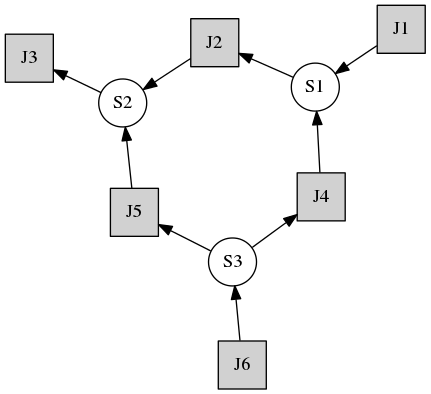

In [8]:
import tellurium as te

# Example of using antimony to create a stoichiometry matrix 
r = te.loada('''
 J1: -> S1; v1;
 J2: S1 -> S2; v2;
 J3: S2 -> ; v3;
 J4: S3 -> S1; v4;
 J5: S3 -> S2; v5;
 J6: -> S3; v6;
 
 v1=1; v2=1; v3=1; v4=1; v5=1; v6=1;
''')

print(r.getFullStoichiometryMatrix())
r.draw()

### Lorenz attractor
Example showing how to describe a model using ODES. Example implements the Lorenz attractor.

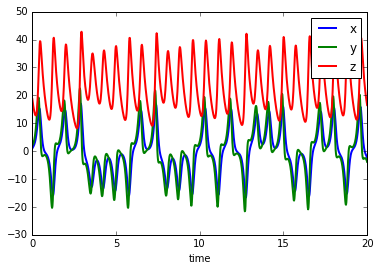

In [9]:
import tellurium as te

r = te.loada ('''
     x' = sigma*(y - x);
     y' = x*(rho - z) - y;
     z' = x*y - beta*z;

     x = 0.96259;  y = 2.07272;  z = 18.65888;

     sigma = 10;  rho = 28; beta = 2.67;
''')

result = r.simulate (0, 20, 1000, ['time', 'x', 'y', 'z'])
r.plot(result);

### Time Course Parameter Scan
Do 5 simulations on a simple model, for each simulation a parameter, `k1` is changed. The script merges the data together and plots the merged array on to one plot.

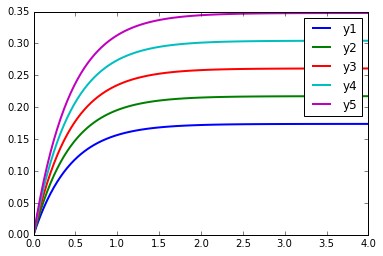

In [10]:
import tellurium as te
import numpy as np

r = te.loada ('''
    J1: $X0 -> S1; k1*X0;
    J2: S1 -> $X1; k2*S1;

    X0 = 1.0; S1 = 0.0; X1 = 0.0;
    k1 = 0.4; k2 = 2.3;
''')  
  
  
m = r.simulate (0, 4, 100, ["Time", "S1"])
for i in range (0,4):
    r.k1 = r.k1 + 0.1 
    r.reset()
    m = np.hstack([m, r.simulate(0, 4, 100, ['S1'])])

# use plotArray to plot merged data
te.plotArray(m);

### Merge multiple simulations
Example of merging multiple simulations. In between simulations a parameter is changed.

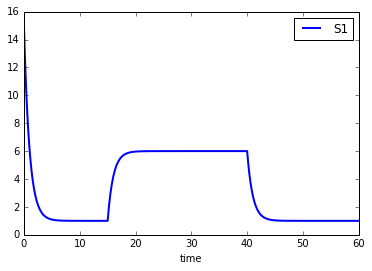

In [11]:
import tellurium as te
import numpy

r = te.loada ('''
    # Model Definition
    v1: $Xo -> S1;  k1*Xo;
    v2: S1 -> $w;   k2*S1;

    # Initialize constants 
    k1 = 1; k2 = 1; S1 = 15; Xo = 1;
''')

# Time course simulation
m1 = r.simulate (0, 15, 100, ["Time","S1"]);
r.k1 = r.k1 * 6;
m2 = r.simulate (15, 40, 100, ["Time","S1"]);
r.k1 = r.k1 / 6;
m3 = r.simulate (40, 60, 100, ["Time","S1"]);

m = numpy.vstack([m1, m2, m3])
r.plot(m);

### Relaxation oscillator
Oscillator that uses positive and negative feedback. An example of a relaxation oscillator.

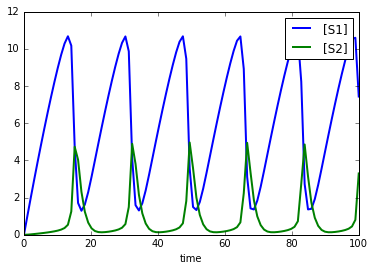

In [12]:
import tellurium as te

r = te.loada ('''
  v1: $Xo -> S1; k1*Xo;
  v2:  S1 -> S2; k2*S1*S2^h/(10 + S2^h) + k3*S1;
  v3:  S2 -> $w; k4*S2;      

  # Initialize
  h  = 2; # Hill coefficient
  k1 = 1; k2 = 2; Xo = 1;
  k3 = 0.02; k4 = 1;
''')

result = r.simulate(0, 100, 100)
r.plot(result);

### Scan hill coefficient
Negative Feedback model where we scan over the value of the Hill coefficient.

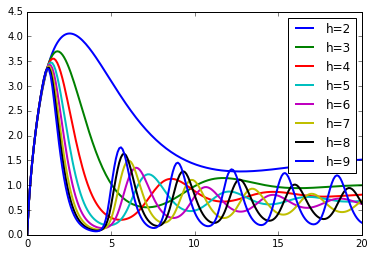

In [13]:
import tellurium as te
import numpy as np

r = te.loada ('''
  // Reactions:
  J0: $X0 => S1; (J0_VM1*(X0 - S1/J0_Keq1))/(1 + X0 + S1 + S4^J0_h);
  J1: S1 => S2; (10*S1 - 2*S2)/(1 + S1 + S2);
  J2: S2 => S3; (10*S2 - 2*S3)/(1 + S2 + S3);
  J3: S3 => S4; (10*S3 - 2*S4)/(1 + S3 + S4);
  J4: S4 => $X1; (J4_V4*S4)/(J4_KS4 + S4);

  // Species initializations:
  S1 = 0;
  S2 = 0;
  S3 = 0;
  S4 = 0;
  X0 = 10;
  X1 = 0;

  // Variable initializations:
  J0_VM1 = 10;
  J0_Keq1 = 10;
  J0_h = 2;
  J4_V4 = 2.5;
  J4_KS4 = 0.5;

  // Other declarations:
  const J0_VM1, J0_Keq1, J0_h, J4_V4, J4_KS4;
''')

# time vector
result = r.simulate (0, 20, 201, ['time'])

h_values = [r.J0_h + k for k in range(0,8)]
for h in h_values:
    r.reset()
    r.J0_h = h
    m = r.simulate(0, 20, 201, ['S1'])
    result = numpy.hstack([result, m])
    
te.plotArray(result, labels=['h={}'.format(int(h)) for h in h_values]);

### Compare simulations

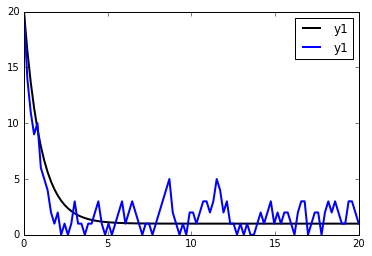

In [14]:
import tellurium as te

r = te.loada ('''
     v1: $Xo -> S1;  k1*Xo;
     v2: S1 -> $w;   k2*S1;

     //initialize.  Deterministic process.
     k1 = 1; k2 = 1; S1 = 20; Xo = 1;
''')

m1 = r.simulate (0,20,100);

# Stochastic process
r.resetToOrigin()
r.setSeed(1234)
m2 = r.gillespie(0, 20, 100, ['time', 'S1'])

# plot all the results together
te.plotArray(m1, color="black", show=False)
te.plotArray(m2, color="blue");

### Sinus injection
Example that show how to inject a sinusoidal into the model and use events to switch it off and on.

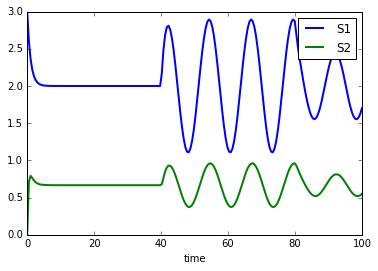

In [15]:
import tellurium as te
import numpy

r = te.loada ('''
    # Inject sin wave into model    
    Xo := sin (time*0.5)*switch + 2;    
    
    # Model Definition
    v1: $Xo -> S1;  k1*Xo;
    v2: S1 -> S2;   k2*S1;
    v3: S2 -> $X1;  k3*S2;

    at (time > 40): switch = 1;
    at (time > 80): switch = 0.5;
    
    # Initialize constants 
    k1 = 1; k2 = 1; k3 = 3; S1 = 3; 
    S2 = 0; 
    switch = 0;
''')

result = r.simulate (0, 100, 200, ['time', 'S1', 'S2'])
r.plot(result);

### Protein phosphorylation cycle
Simple protein phosphorylation cycle. Steady state concentation of the phosphorylated protein is plotted as a funtion of the cycle kinase. In addition, the plot is repeated for various values of Km.

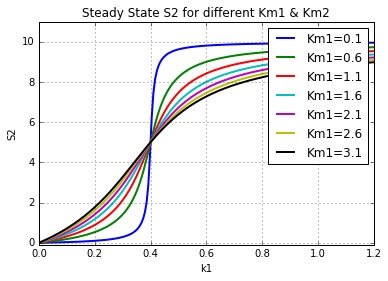

In [16]:
import tellurium as te
import numpy as np

r = te.loada ('''
   S1 -> S2; k1*S1/(Km1 + S1);
   S2 -> S1; k2*S2/(Km2 + S2);
   
   k1 = 0.1; k2 = 0.4; S1 = 10; S2 = 0;
   Km1 = 0.1; Km2 = 0.1;  
''')

r.conservedMoietyAnalysis = True

for i in range (1,8):
  numbers = np.linspace (0, 1.2, 200)
  result = np.empty ([0,2])
  for value in numbers:
      r.k1 = value
      r.steadyState()
      row = np.array ([value, r.S2])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Km1={}'.format(r.Km1)],
               resetColorCycle=False,
               xlabel='k1', ylabel="S2", 
               title="Steady State S2 for different Km1 & Km2",
               ylim=[-0.1, 11], grid=True)
  r.k1 = 0.1
  r.Km1 = r.Km1 + 0.5;
  r.Km2 = r.Km2 + 0.5;